In [1]:
import os

# Install java
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.5.3

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 34kB/s 
     |████████████████████████████████| 204kB 55.5MB/s 
     |████████████████████████████████| 133kB 6.5MB/s 


In [2]:
# Run this in console to keep Co Lab Running
'''
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
'''

'\nfunction ConnectButton(){\n    console.log("Connect pushed"); \n    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [3]:
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.ml import Pipeline
from pyspark.ml.tuning import TrainValidationSplit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Start Spark session
spark = sparknlp.start()

In [5]:
# Best practice to print versions
print("Spark NLP version", sparknlp.version())
print("Apache Spark version", spark.version)

Spark NLP version 2.5.3
Apache Spark version 2.4.4


In [6]:
# Yin genius way of loading Amazon Data
file = 'amazon_reviews_us_Pet_Products_v1_00.tsv.gz'
os.system(f'wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/{file}')
df = pd.read_csv(file, compression='gzip', header=0, sep='\t', error_bad_lines=False)

b'Skipping line 21404: expected 15 fields, saw 22\nSkipping line 31839: expected 15 fields, saw 22\nSkipping line 37779: expected 15 fields, saw 22\nSkipping line 38344: expected 15 fields, saw 22\nSkipping line 61449: expected 15 fields, saw 22\n'
b'Skipping line 80975: expected 15 fields, saw 22\nSkipping line 85603: expected 15 fields, saw 22\nSkipping line 95950: expected 15 fields, saw 22\nSkipping line 105132: expected 15 fields, saw 22\nSkipping line 115378: expected 15 fields, saw 22\n'
b'Skipping line 152632: expected 15 fields, saw 22\nSkipping line 159310: expected 15 fields, saw 22\nSkipping line 162724: expected 15 fields, saw 22\nSkipping line 168588: expected 15 fields, saw 22\nSkipping line 170412: expected 15 fields, saw 22\nSkipping line 187169: expected 15 fields, saw 22\n'
b'Skipping line 205461: expected 15 fields, saw 22\nSkipping line 210928: expected 15 fields, saw 22\nSkipping line 213691: expected 15 fields, saw 22\nSkipping line 228697: expected 15 fields, sa

In [7]:
df1= df
#headline_updated = df1["review_headline"].str.contains("One Star|Two Stars|Three Stars|Four Stars|Five Stars",na=False)
#df1.drop(headline_updated[headline_updated].index,axis=0,inplace=True)
df1[["star_rating","review_body"]]= df1[["star_rating","review_body"]].astype(str)
df1.star_rating.value_counts()


5.0    1643151
4.0     380780
1.0     248519
3.0     216335
2.0     151067
nan          1
Name: star_rating, dtype: int64

In [8]:
df1.loc[df1["star_rating"]=="2.0","star_rating"]="3.0" 
df1.loc[df1["star_rating"]=="4.0","star_rating"]="3.0"
df_1 = df1.loc[df1["star_rating"]=="1.0"]
#df_2 = df1.loc[df1["star_rating"]=="2.0"]
df_3 = df1.loc[df1["star_rating"]=="3.0"]
#df_4 = df1.loc[df1["star_rating"]=="4.0"]
df_5 = df1.loc[df1["star_rating"]=="5.0"]

df_star1= df_1.sample(n = 151067, replace = True) 
#df_star2= df_2.sample(n = 151067, replace = True) 
df_star3= df_3.sample(n = 151067, replace = True) 
#df_star4= df_4.sample(n = 151067, replace = True) 
df_star5= df_5.sample(n = 151067, replace = True) 

frames = [df_star1, df_star3,df_star5]

df_sample = pd.concat(frames)
df_sample[["star_rating","review_body"]]= df[["star_rating","review_body"]].astype(str)



In [9]:
df_sample["review_body"]= df_sample["review_body"].str.lower()
#set(reviews([1])

for i in range(10):
  #print(df_sample.iloc[i,13])
  df_sample.iloc[i,13] = ' '.join(list(set(df_sample.iloc[i,13].split())))
  #reviews.at[i,'review_body']=(" ".join(list(set(reviews.at[i,'review_body']))))
df_sample['review_body'].head(10)

423944     pad was quality buy expecting. them again. not...
620229                                              returned
2047167    stopped frontline working it's i'm to miserabl...
1338147    was brand. chew pieces in to all foam time. sq...
1195425    itself. thread it's to does in of has the fit ...
2441701    even was looked packed used, had amazon. recei...
812092     was one in tore condition- i good of the expec...
2021516    gets these, carry.<br pieces fabric perfectly ...
85273      dark where did make had to fine in soiled. cat...
2440027    sporadic. was worked on. manner. collar could ...
Name: review_body, dtype: object

In [10]:
df_sample["length_comment"]= df["review_body"].str.split().str.len()

print(df_sample["length_comment"])

423944      12
620229       1
2047167     33
1338147     41
1195425    173
          ... 
1037853     13
757110       3
110376       4
936253       7
2564698     75
Name: length_comment, Length: 453201, dtype: int64


In [11]:
sample_df = df_sample[["star_rating","review_body","length_comment"]]
sample_df.reset_index(inplace = True) 
sample_df

,index,star_rating,review_body,length_comment
0,423944,1.0,pad was quality buy expecting. them again. not...,12
1,620229,1.0,returned,1
2,2047167,1.0,stopped frontline working it's i'm to miserabl...,33
3,1338147,1.0,was brand. chew pieces in to all foam time. sq...,41
4,1195425,1.0,itself. thread it's to does in of has the fit ...,173
...,...,...,...,...
453196,1037853,5.0,makes a nicer way to keep a liter box out in t...,13
453197,757110,5.0,cat loves it,3
453198,110376,5.0,our dogs love it,4
453199,936253,5.0,great size and quality. shipping was fast.,7


In [12]:
sample_df.describe()

,index,length_comment
count,4.532010e+05,453201.000000
mean,1.336195e+06,60.022981
std,7.686704e+05,79.732858
min,5.000000e+00,1.000000
25%,6.667530e+05,20.000000
50%,1.345952e+06,37.000000
75%,2.006638e+06,73.000000
max,2.639849e+06,4213.000000


Text(0, 0.5, 'number of reviews')

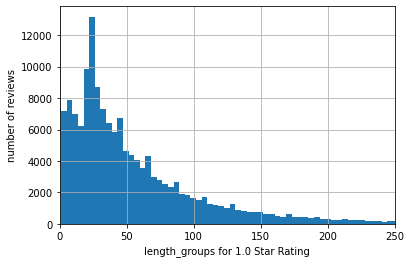

In [13]:

hist=sample_df[sample_df['star_rating'] == '1.0']["length_comment"].hist(bins=1000)
hist.set_xlim((0,250))
hist.set_xlabel("length_groups for 1.0 Star Rating")
hist.set_ylabel("number of reviews")


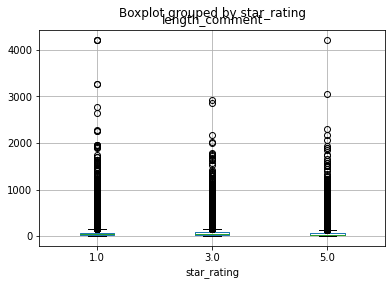

In [14]:
sample_df.boxplot(column="length_comment", by="star_rating")

In [15]:
sample_df= sample_df[(sample_df['length_comment'] >= 5) & (sample_df['length_comment'] <= 139)]

In [16]:
sample_df

,index,star_rating,review_body,length_comment
0,423944,1.0,pad was quality buy expecting. them again. not...,12
2,2047167,1.0,stopped frontline working it's i'm to miserabl...,33
3,1338147,1.0,was brand. chew pieces in to all foam time. sq...,41
5,2441701,1.0,"even was looked packed used, had amazon. recei...",84
6,812092,1.0,was one in tore condition- i good of the expec...,50
...,...,...,...,...
453193,2059058,5.0,it is made with no fillers and my dog has been...,46
453194,1054095,5.0,"great deshedding tool for cats, keeps hair out...",15
453196,1037853,5.0,makes a nicer way to keep a liter box out in t...,13
453199,936253,5.0,great size and quality. shipping was fast.,7


In [18]:
# Select out features and labels
entireDataset = spark.createDataFrame(sample_df[['star_rating', 'review_body']])

In [19]:
# Check data types
entireDataset.dtypes

[('star_rating', 'string'), ('review_body', 'string')]

In [20]:
# View col names
entireDataset.columns

['star_rating', 'review_body']

In [21]:
# Change object to string
entireDataset.review_body = entireDataset.review_body.astype('string')

In [22]:
# Prepare for NLP pipeline with initial DocumentAssembler
# Content is inside review_body
document = DocumentAssembler() \
  .setInputCol("review_body") \
  .setOutputCol("document")

In [23]:
# Using sentence detector (pretrained)
# Sentence detector
use = UniversalSentenceEncoder.pretrained() \
  .setInputCols(["document"]) \
  . setOutputCol("sentence_embeddings")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [24]:
# Our labels / classes are the 1 - 5 star ratings
# These are in the star_rating col

classifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("star_rating")\
  .setMaxEpochs(30)\
  .setEnableOutputLogs(True)

In [25]:
# Declare the pipeline
use_clf_pipeline = Pipeline(
  stages = [
    document,
    use,
    classifierdl
  ]
)



In [26]:
# Split into training and testing data
trainDataset, testDataset = entireDataset.randomSplit([0.75, 0.25], seed=12345)


In [27]:
# Begin fitting on the data
use_pipelineModel = use_clf_pipeline.fit(trainDataset)

In [28]:
# Set predictions on testDataset
predictions = use_pipelineModel.transform(testDataset)
predictions.count()
predictions.show()

+-----------+--------------------+--------------------+--------------------+--------------------+
|star_rating|         review_body|            document| sentence_embeddings|               class|
+-----------+--------------------+--------------------+--------------------+--------------------+
|        1.0|$1,000,000.00????...|[[document, 0, 46...|[[sentence_embedd...|[[category, 0, 46...|
|        1.0|$13/pound and you...|[[document, 0, 23...|[[sentence_embedd...|[[category, 0, 23...|
|        1.0|$14.17 is quite r...|[[document, 0, 25...|[[sentence_embedd...|[[category, 0, 25...|
|        1.0|$17.99  i paid fo...|[[document, 0, 11...|[[sentence_embedd...|[[category, 0, 11...|
|        1.0|$17.99  i paid fo...|[[document, 0, 11...|[[sentence_embedd...|[[category, 0, 11...|
|        1.0|$18 dollars and i...|[[document, 0, 17...|[[sentence_embedd...|[[category, 0, 17...|
|        1.0|$40+ for fleece m...|[[document, 0, 11...|[[sentence_embedd...|[[category, 0, 11...|
|        1.0|$76.95,

In [29]:
# Begin fitting on the data
use_pipelineModel = use_clf_pipeline.fit(trainDataset)

In [30]:
# Set predictions on testDataset
predictions = use_pipelineModel.transform(testDataset)

In [31]:

# Run predictions
predictions.select('star_rating','review_body', 'class.result').show(10, truncate=80)

+-----------+--------------------------------------------------------------------------------+------+
|star_rating|                                                                     review_body|result|
+-----------+--------------------------------------------------------------------------------+------+
|        1.0|                                 $1,000,000.00??????  this stuff better be good!| [5.0]|
|        1.0|$13/pound and you actually have to feed more of it to your dog than normal we...| [1.0]|
|        1.0|$14.17 is quite reasonable for a pack of 6, however, i received one package o...| [1.0]|
|        1.0|$17.99  i paid for this bag 1.8 small small cost 4.00 in wallmart.... do not ...| [1.0]|
|        1.0|$17.99  i paid for this bag 1.8 small small cost 4.00 in wallmart.... do not ...| [1.0]|
|        1.0|$18 dollars and it didn't even last two hours!  our two dogs have been playin...| [1.0]|
|        1.0|$40+ for fleece material? i have the same ones from dollar store for 

In [32]:
# Import reports for quantifying results
from sklearn.metrics import classification_report, accuracy_score

df = use_pipelineModel.transform(testDataset).select('star_rating','review_body', 'class.result').toPandas()

df['result'] = df['result'].apply(lambda x: x[0])

In [33]:
df.result = df.result.astype(str)

In [34]:
print(classification_report(df['star_rating'], df.result))
print(accuracy_score(df['star_rating'], df.result))

              precision    recall  f1-score   support

         1.0       0.75      0.82      0.78     33069
         3.0       0.63      0.55      0.59     32443
         5.0       0.74      0.76      0.75     31701

    accuracy                           0.71     97213
   macro avg       0.70      0.71      0.71     97213
weighted avg       0.70      0.71      0.71     97213

0.7097919002602533
